# Simulation Waterfall

In [31]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(seed=42)

In [32]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        
    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None
        
        if -1 < pop_ix < len(self.queue):
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

In [33]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [67]:
class Waterfall():
    
    def __init__(self,
                 arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 test_servers_nb,
                 front_servers_nb,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x:0,
                 front_policy=lambda x: 0,
                 test_size=100):
        #Initializing metadata
        self.arval_dist = arval_dist
        
        self.test_srv_dist = test_srv_dist
        self.front_srv_dist = front_srv_dist
        
        self.test_servers_nb = test_servers_nb
        self.front_servers_nb = front_servers_nb
        
        self.test_queue_size = test_queue_size if test_queue_size else test_size
        self.front_queue_size = front_queue_size if front_queue_size else test_size
        
        self.test_size = test_size

        #Initializing Waiting Lines
        self.wline_test = Wline(size=test_queue_size, policy=test_policy)
        self.wline_front = Wline(size=front_queue_size, policy=front_policy)
        
        #Initializing In Service Lists
        self.test_inservice = InService(nb=test_servers_nb, dist=test_srv_dist)
        self.front_inservice = InService(nb=front_servers_nb, dist=front_srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_test_queue', 't_arval_test_srv', 't_arval_front_queue', 't_arval_front_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, len(column_names)), dtype=object), columns=column_names)
        
    def pretreat(self):
        #Generate inter-arrivals time in the test queue for each user
        t_interarvals = self.arval_dist(size=(self.test_size))
        self.tops.loc[0, 't_arval_queue'] = t_interarvals[0]
        #Convert inter-arrival to timestamp of arrival (cumulative sum)
        for agent in range(1, self.test_size) :
            self.tops.loc[agent, 't_arval_queue'] = self.tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        
    def run(self):
        #Initializing arrival queue
        self.wline_test.queue = list(self.tops.loc[0:0].index)
        #Initializing upcomgin theoretical arrival        
        buffer_ix = 1 
    
        while buffer_ix < self.test_size:
            _next = self.wline_test.pop()
            if _next is not None: #Waiting line is not empty 
                #Update server arrival time as if no waiting was needed
                self.tops.loc[_next, 't_arval_srv'] = self.tops.loc[_next, 't_arval_queue']
                
                #Find next available server
                srv_ix, dept_ag = self.test_inservice.leaving(self.tops)
    
                #Fill available server with corresponding next agent in waiting line
                self.test_inservice.server[srv_ix] = _next 
                    
                if dept_ag is not None :
                    if self.tops.loc[_next, 't_arval_queue'] < self.tops.loc[dept_ag, 't_depart_sys'] : 
                        #Update server arrival time in case arrival is before system departure
                        self.tops.loc[_next, 't_arval_srv'] = self.tops.loc[dept_ag, 't_depart_sys']
                        
                #Update system departure time
                self.tops.loc[_next, 't_depart_sys'] = self.tops.loc[_next, 't_arval_srv'] + self.test_inservice.dist() 
                                            
            #Counting prior agents still in system
            in_system = (self.tops.loc[0:buffer_ix - 1, 't_depart_sys'] > self.tops.loc[buffer_ix, 't_arval_queue']).sum()
                            
            if self.test_queue_size is not None and in_system >= self.test_queue_size + self.test_inservice.nb:
                self.tops.loc[buffer_ix, 't_depart_sys'] = -1
            else:
                self.wline_test.queue.append(buffer_ix)
                    
            buffer_ix += 1
                
    def posttreat(self):   
        self.tops['t_sojourn'] = np.where(self.tops['t_depart_sys'] == -1, 0, self.tops['t_depart_sys'] - self.tops['t_arval_queue'])
        self.tops['t_waiting'] = np.where(self.tops['t_depart_sys'] == -1, 0, self.tops['t_arval_srv'] - self.tops['t_arval_queue'])
        self.tops['t_service'] = np.where(self.tops['t_depart_sys'] == -1, 0, self.tops['t_depart_sys'] - self.tops['t_arval_srv'])
        self.tops['blocked'] = self.tops.loc[:,'t_depart_sys'] == -1
        self.tops['waited'] = self.tops['t_waiting'] > 0 
    
    def timeline(self, t_delation=2):
        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., self.tops['t_depart_sys'].max(), t_delation * self.test_size)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= self.tops['t_arval_queue']) & (t <= self.tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= self.tops['t_arval_queue']) & (t <= self.tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > self.tops['t_arval_srv']) & (t <= self.tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1), dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = self.tops['t_sojourn'].sum() / (~self.tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = self.tops['t_waiting'].sum() / (~self.tops['blocked']).sum()
        stats.loc['mean_service_time'] = self.tops['t_service'].sum() / (~self.tops['blocked']).sum()

        stats.loc['waiting_proportion'] = self.tops['waited'].sum() / (~self.tops['blocked']).sum()
        stats.loc['blocked_proportion'] = self.tops['blocked'].sum() / self.test_size

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.test_inservice.nb).sum() / (t_delation * self.test_size - 1)

        return process, stats
        
    def simulate(self):
        self.pretreat()
        self.run()
        self.posttreat()

In [171]:
import numpy as np
import pandas as pd

class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        self.queue = []

    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None
        
        if -1 < pop_ix < len(self.queue):
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

class InService():
    
    def __init__(self, nb=1, dist=None, depart_col='t_depart_sys'):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        self.depart_col = depart_col
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            # Find first available server
            srv_ix = self.server.index(None) 
        
        else:
            # Extract agent with earliest departure in this stage
            agent_id = tops.loc[self.server, self.depart_col].astype(float).idxmin()
            srv_ix = self.server.index(agent_id)
        
        return srv_ix, agent_id

class Waterfall():
    
    def __init__(self,
                 arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 test_servers_nb,
                 front_servers_nb,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x: 0,
                 front_policy=lambda x: 0,
                 test_size=100):

        # Distributions
        self.arval_dist = arval_dist
        self.test_srv_dist = test_srv_dist
        self.front_srv_dist = front_srv_dist
        
        # Servers and queue sizes
        self.test_servers_nb = test_servers_nb
        self.front_servers_nb = front_servers_nb
        
        self.test_queue_size = test_queue_size if test_queue_size else test_size
        self.front_queue_size = front_queue_size if front_queue_size else test_size
        
        self.test_size = test_size

        # Waiting lines
        self.wline_test = Wline(size=test_queue_size, policy=test_policy)
        self.wline_front = Wline(size=front_queue_size, policy=front_policy)
        
        # Servers with correct departure field references
        self.test_inservice = InService(
            nb=test_servers_nb, 
            dist=test_srv_dist,
            depart_col='t_depart_test'
        )
        
        self.front_inservice = InService(
            nb=front_servers_nb, 
            dist=front_srv_dist,
            depart_col='t_depart_sys'
        )
        
        # Dataframe initialization
        column_names = [
            't_arval_test_queue',
            't_arval_test_srv',
            't_depart_test',
            't_arval_front_queue',
            't_arval_front_srv',
            't_depart_sys'
        ]
        
        self.tops = pd.DataFrame(
            np.empty((test_size, len(column_names)), dtype=object), 
            columns=column_names
        )
        
    # -------------------------------------------------
    def pretreat(self):
        """Generate arrival times for TEST queue."""
        t_inter = self.arval_dist(size=(self.test_size))
        self.tops.loc[0, 't_arval_test_queue'] = t_inter[0]
        
        for i in range(1, self.test_size):
            self.tops.loc[i, 't_arval_test_queue'] = \
                self.tops.loc[i-1, 't_arval_test_queue'] + t_inter[i]

    # -------------------------------------------------
    def run(self):
        """Simulate test queue → test servers → front queue → front servers."""
        
        # ==============================
        #     1. TEST QUEUE STAGE
        # ==============================
        self.wline_test.queue = [0]
        nxt = 1
        
        while nxt < self.test_size:
            agent = self.wline_test.pop()
            
            if agent is not None:
                # server arrival
                self.tops.loc[agent, 't_arval_test_srv'] = \
                    self.tops.loc[agent, 't_arval_test_queue']

                # find server
                srv_ix, dept_ag = self.test_inservice.leaving(self.tops)
                self.test_inservice.server[srv_ix] = agent

                # if server is busy, update arrival time
                if dept_ag is not None:
                    if self.tops.loc[agent, 't_arval_test_queue'] < \
                       self.tops.loc[dept_ag, 't_depart_test']:
                        self.tops.loc[agent, 't_arval_test_srv'] = \
                            self.tops.loc[dept_ag, 't_depart_test']

                # departure from test stage
                self.tops.loc[agent, 't_depart_test'] = \
                    self.tops.loc[agent, 't_arval_test_srv'] + self.test_inservice.dist()
            
            # evaluate admission of next arrival
            in_system = (self.tops.loc[0:nxt-1, 't_depart_test'] > 
                         self.tops.loc[nxt, 't_arval_test_queue']).sum()

            if self.test_queue_size is not None and \
               in_system >= self.test_queue_size + self.test_inservice.nb:
                # blocked at test
                self.tops.loc[nxt, 't_depart_test'] = -1
            else:
                self.wline_test.queue.append(nxt)

            nxt += 1
        
        
        # ==============================
        #     2. FRONT QUEUE STAGE
        # ==============================
        
        entering = self.tops[self.tops['t_depart_test'] != -1].index
        if len(entering) == 0:
            return
        
        # Initialize
        entering = list(entering)
        first = entering[0]

        self.wline_front.queue = [first]
        self.tops.loc[first, 't_arval_front_queue'] = self.tops.loc[first, 't_depart_test']
        
        pos = 1
        
        while pos < len(entering):
            agent = self.wline_front.pop()
            
            if agent is not None:
                self.tops.loc[agent, 't_arval_front_srv'] = \
                    self.tops.loc[agent, 't_arval_front_queue']

                srv_ix, dept_ag = self.front_inservice.leaving(self.tops)
                self.front_inservice.server[srv_ix] = agent

                if dept_ag is not None:
                    if self.tops.loc[agent, 't_arval_front_queue'] < \
                       self.tops.loc[dept_ag, 't_depart_sys']:
                        self.tops.loc[agent, 't_arval_front_srv'] = \
                            self.tops.loc[dept_ag, 't_depart_sys']

                # final departure
                self.tops.loc[agent, 't_depart_sys'] = \
                    self.tops.loc[agent, 't_arval_front_srv'] + self.front_inservice.dist()

            
            next_agent = entering[pos]
            self.tops.loc[next_agent, 't_arval_front_queue'] = \
                self.tops.loc[next_agent, 't_depart_test']

            in_front = (self.tops.loc[entering[:pos], 't_depart_sys'] > 
                        self.tops.loc[next_agent, 't_arval_front_queue']).sum()

            if self.front_queue_size is not None and \
               in_front >= self.front_queue_size + self.front_inservice.nb:
                self.tops.loc[next_agent, 't_depart_sys'] = -1
            else:
                self.wline_front.queue.append(next_agent)

            pos += 1

    # -------------------------------------------------
    def posttreat(self):
        """Compute final stats and classify customers."""
        
        # which customers were blocked
        self.tops['blocked_test'] = self.tops['t_depart_test'] == -1
        self.tops['blocked_front'] = (~self.tops['blocked_test']) & (self.tops['t_depart_sys'] == -1)

        # arrival times may be missing for blocked front customers
        self.tops['t_depart_sys'] = (
    pd.to_numeric(self.tops['t_depart_sys'], errors='coerce').fillna(-1))

        # ==========================
        # Waiting times
        # ==========================
        self.tops['t_wait_test'] = np.where(
            self.tops['t_depart_test'] == -1, 
            0,
            self.tops['t_arval_test_srv'] - self.tops['t_arval_test_queue']
        )

        self.tops['t_wait_front'] = np.where(
            (self.tops['t_depart_sys'] == -1) | self.tops['blocked_test'],
            0,
            self.tops['t_arval_front_srv'] - self.tops['t_arval_front_queue']
        )

        # ==========================
        # Service times
        # ==========================
        self.tops['t_srv_test'] = np.where(
            self.tops['t_depart_test'] == -1, 
            0,
            self.tops['t_depart_test'] - self.tops['t_arval_test_srv']
        )

        self.tops['t_srv_front'] = np.where(
            self.tops['t_depart_sys'] == -1,
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_front_srv']
        )

        # ==========================
        # Total time in system
        # ==========================
        self.tops['t_sojourn'] = np.where(
            self.tops['t_depart_sys'] == -1, 
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_test_queue']
        )

    # -------------------------------------------------
    def timeline(self, t_delation=2):
        """Full-system timeline."""
        
        tmax = self.tops['t_depart_sys'].replace(-1, np.nan).max()
        t_range = np.linspace(0, tmax, t_delation * self.test_size)

        cols = [
            'in_test_queue', 'in_test_srv',
            'in_front_queue', 'in_front_srv',
            'in_system'
        ]

        timeline = pd.DataFrame(index=t_range, columns=cols)

        for t in t_range:

            timeline.loc[t, 'in_test_queue'] = \
                ((t >= self.tops['t_arval_test_queue']) &
                 (t <= self.tops['t_arval_test_srv'])).sum()

            timeline.loc[t, 'in_test_srv'] = \
                ((t >= self.tops['t_arval_test_srv']) &
                 (t <= self.tops['t_depart_test'])).sum()

            timeline.loc[t, 'in_front_queue'] = \
                ((t >= self.tops['t_arval_front_queue']) &
                 (t <= self.tops['t_arval_front_srv'])).sum()

            timeline.loc[t, 'in_front_srv'] = \
                ((t >= self.tops['t_arval_front_srv']) &
                 (t <= self.tops['t_depart_sys'])).sum()

            timeline.loc[t, 'in_system'] = \
                ((t >= self.tops['t_arval_test_queue']) &
                 (t <= self.tops['t_depart_sys'])).sum()

        stats = {
            'mean_wait_test': self.tops['t_wait_test'].mean(),
            'mean_wait_front': self.tops['t_wait_front'].mean(),
            'mean_srv_test': self.tops['t_srv_test'].mean(),
            'mean_srv_front': self.tops['t_srv_front'].mean(),
            'blocked_at_test': self.tops['blocked_test'].mean(),
            'blocked_at_front': self.tops['blocked_front'].mean(),
            'mean_sojourn': self.tops['t_sojourn'].mean(),
            'test_busy_fraction': (timeline['in_test_srv'] == self.test_servers_nb).mean(),
            'front_busy_fraction': (timeline['in_front_srv'] == self.front_servers_nb).mean()
        }

        return timeline, pd.DataFrame.from_dict(stats, orient='index', columns=['value'])
    
    # -------------------------------------------------
    def simulate(self):
        self.pretreat()
        self.run()
        self.posttreat()


In [182]:
# Waiting system parameters
lambdaa = 10
mu_test = 20
mu_front = 20
k = 3

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_test)
front_srv_dist = lambda : rng.exponential(1./mu_front)

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x:0,
                 front_policy=lambda x: 0,
                 test_size=100)

In [183]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_wait_test,0.000073
mean_wait_front,0.124243
mean_srv_test,0.044259
mean_srv_front,0.049201
blocked_at_test,0.000000
blocked_at_front,0.000000
mean_sojourn,0.217333
test_busy_fraction,0.010000
front_busy_fraction,0.610000


In [184]:
bench

,in_test_queue,in_test_srv,in_front_queue,in_front_srv,in_system
0.000000,0,0,0,0,0
0.040725,0,0,0,0,0
0.081450,0,1,0,0,1
0.122175,0,0,0,0,0
0.162900,0,1,0,0,1
...,...,...,...,...,...
7.941399,0,0,4,1,5
7.982124,0,0,4,1,5
8.022849,0,0,3,1,4
8.063574,0,0,1,1,2


In [185]:
import matplotlib.pyplot as plt

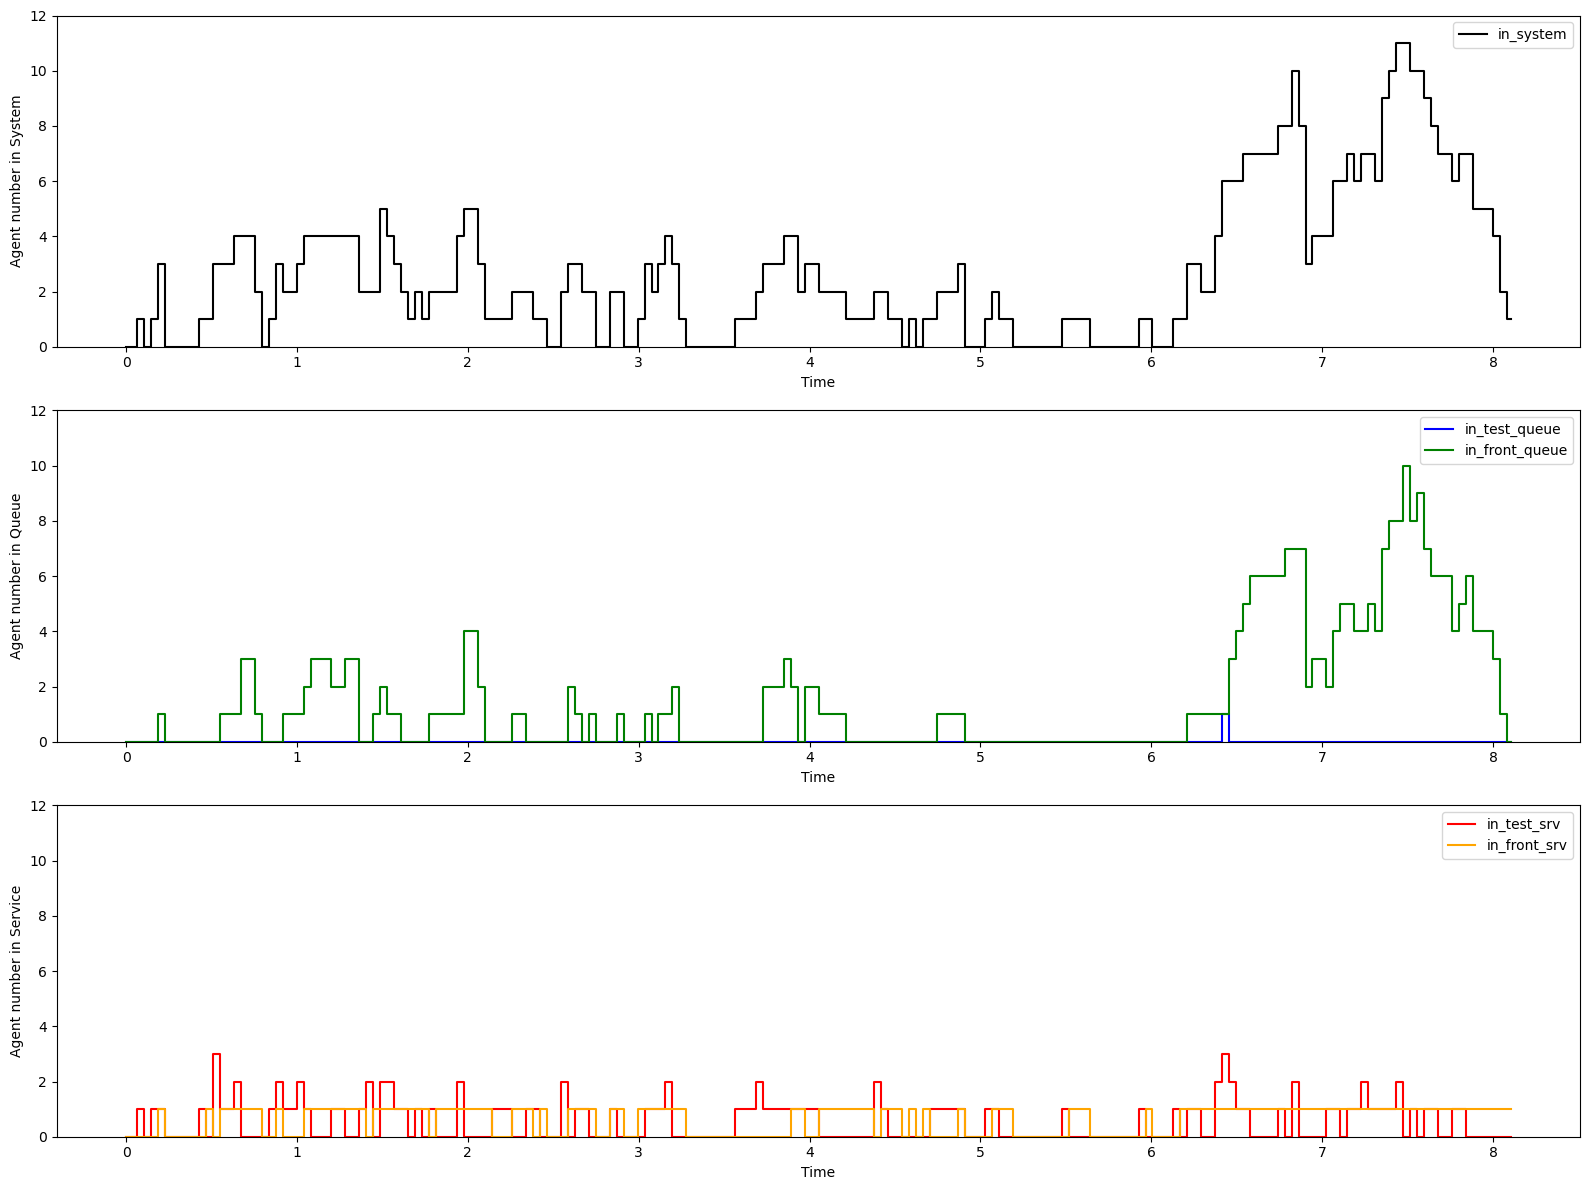

In [186]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Define columns to plot
counts = [
    'in_system',                        # total in system
    ['in_test_queue', 'in_front_queue'], # queues
    ['in_test_srv', 'in_front_srv']     # services
]

labels = ['System', 'Queue', 'Service']
colors = [
    ['black'],                     # total system
    ['blue', 'green'],             # test queue = blue, front queue = green
    ['red', 'orange']              # test service = red, front service = orange
]

for i in range(3):
    if isinstance(counts[i], list):
        # multiple lines
        for j, col in enumerate(counts[i]):
            bench.plot(y=col, use_index=True, ax=axes[i], linewidth=1.5,
                       drawstyle='steps-mid', color=colors[i][j],
                       label=col)
        axes[i].legend()
    else:
        # single line
        bench.plot(y=counts[i], use_index=True, ax=axes[i], linewidth=1.5,
                   drawstyle='steps-mid', color=colors[i][0])
    
    axes[i].set_ylabel(f'Agent number in {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylim(0, max(bench['in_system']+1))

plt.tight_layout()
plt.show()
